# Pose Bowl: Object Detection

<a id="import-libraries"></a>

# 📚 | Import Libraries 

In [59]:
# File handling
import sys
from pathlib import Path
sys.path.append('/Users/jsh/code/drivendata/spacecrafts/')
from PIL import Image

# Pre-processing and visualization
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Modelling
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.io import read_image
from torchvision.transforms import transforms, v2
import pytorch_lightning as L
from pytorch_lightning.tuner import Tuner
from pytorch_lightning.callbacks import ModelSummary
from scripts.score import jaccard_index

from spacecraft_dataset import SpacecraftDataset, collate_fn

<a id="configuration"></a>
# ⚙️ | Configuration

In [60]:
PROJ_DIRECTORY = Path.cwd().parent
DATA_DIRECTORY = PROJ_DIRECTORY / "data"
DEV_DIRECTORY = PROJ_DIRECTORY / "data_dev"
IMAGES_DIRECTORY = DEV_DIRECTORY / "images"
IMAGE_SIZE = (1280, 1024)
IMAGE_RESIZE_SCALE = (1/8)
IMAGE_RESIZED = (int(IMAGE_SIZE[0]*IMAGE_RESIZE_SCALE), int(IMAGE_SIZE[1]*IMAGE_RESIZE_SCALE))

<a id="datasets"></a>
# 🍚 | Datasets

In [61]:
train_meta = pd.read_csv(DEV_DIRECTORY / "train_metadata.csv", index_col="image_id")
train_labels = pd.read_csv(DEV_DIRECTORY / "train_labels.csv", index_col="image_id")
train_meta.shape, train_labels.shape

((25801, 2), (25801, 4))

In [62]:
train_labels.head()

,xmin,ymin,xmax,ymax
image_id,,,,
0001954c9f4a58f7ac05358b3cda8d20,0,277,345,709
00054819240f9d46378288b215dbcd3a,753,602,932,725
000dbf763348037b46558bbcb6a032ac,160,434,203,481
000e79208bebd8e84ce6c22fd8612a0d,70,534,211,586
000f13aff94499d03e3997afc55b0aa0,103,0,312,193


In [63]:
train_meta.head()

,spacecraft_id,background_id
image_id,,
0001954c9f4a58f7ac05358b3cda8d20,24,247
00054819240f9d46378288b215dbcd3a,14,10
000dbf763348037b46558bbcb6a032ac,19,17
000e79208bebd8e84ce6c22fd8612a0d,14,15
000f13aff94499d03e3997afc55b0aa0,28,15


In [64]:
# Examine an example image
example_img_idx = '000e79208bebd8e84ce6c22fd8612a0d'
example_img_path = Path(IMAGES_DIRECTORY, example_img_idx + '.png')
example_img = Image.open(str(example_img_path))
print('Original image', example_img.format, example_img.size, example_img.mode)

example_img = example_img.resize((int(example_img.size[0]*0.5), int(example_img.size[1]*0.5)), resample=Image.Resampling.LANCZOS)
transform = transforms.Compose([
    transforms.ToTensor(),
])

example_img = transform(example_img)

if example_img.min() >= 0 and example_img.max() <= 1:
    print("Image pixel values are in the range [0, 1].")
else:
    print("Image pixel values are not in the range [0, 1].")

print('Transformed image', example_img.shape)

Original image PNG (1280, 1024) RGB
Image pixel values are in the range [0, 1].
Transformed image torch.Size([3, 512, 640])


In [65]:
# Create pytorch Dataset
class SpacecraftDataset(torch.utils.data.Dataset):
    def __init__(self, labels_df, meta_df, imgs_dir=None, transforms=None, resize=None):
        self.imgs_dir = imgs_dir
        self.labels_df = labels_df # dataframe of indexes and bbox coordinates
        self.meta_df = meta_df
        self.img_idxs = labels_df.index.tolist()
        self.transforms = transforms
        self.resize = resize # resize the images for faster prototyping
    
    def __getitem__(self, idx):
        # Get image id and path
        img_id = self.img_idxs[idx]
        img_path = str(Path(self.imgs_dir, img_id + '.png'))
        n_objs = 1
        
        # Load image
        img = Image.open(img_path)

        # Get spacecraft id
        labels = torch.ones(n_objs, dtype=torch.int64)

        # Get bbox coordinates
        bbox = self._get_bbox(img_id)

        # Resize image and bounding box if resize parameter is provided
        if self.resize is not None:
            img, bbox = self._resize(img, bbox)
        
        # Convert data to format needed by model.
        target = {}
        target['boxes'] = torch.from_numpy(bbox).reshape((1,4))
        target['labels'] = labels
        target['image_id'] = img_id

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target
    
    def __len__(self):
        return len(self.img_idxs)

    def _get_bbox(self, image_id):
        return self.labels_df.loc[image_id].loc[["xmin", "ymin", "xmax", "ymax"]].values.astype('int')
    
    def _resize(self, img, bbox):
        # Resize image
        img = img.resize((int(img.size[0]*self.resize), int(img.size[1]*self.resize)), resample=Image.Resampling.LANCZOS)

        # Resize bounding box
        bbox[0] = int(bbox[0] * self.resize)
        bbox[1] = int(bbox[1] * self.resize)
        bbox[2] = int(bbox[2] * self.resize)
        bbox[3] = int(bbox[3] * self.resize)

        return img, bbox
    
# Define collate function to manage dictionary style dataset.
def collate_fn(batch):
    return list(zip(*batch))

In [66]:
# Create a Lightning DataModule to wrap the dataset.
class SpacecraftDataModule(L.LightningDataModule):
    def __init__(self, dataset=None, batch_size=4):
        super().__init__()
        self.dataset = dataset
        self.batch_size=batch_size
    
    def prepare_data(self):
        pass

    def setup(self, stage=None):
        self.train_ds = Subset(self.dataset, torch.arange(100))
        self.valid_ds = Subset(self.dataset, torch.arange(100, 150))

    def train_dataloader(self):
        return DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            shuffle=False,
            # num_workers=9,
            # persistent_workers=True,
            collate_fn=collate_fn
        )

    def val_dataloader(self):
        return DataLoader(
            self.valid_ds,
            batch_size=self.batch_size,
            shuffle=False,
            # num_workers=9,
            # persistent_workers=True,
            collate_fn=collate_fn
        )

<a id="model"></a>
# 🤖 | Model

In [67]:
# Download base model
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(weights="DEFAULT")

# Adjust the model for spacecraft recognition task.
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

num_classes = 2 # 2 classes are spacecraft or background
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace pre-trained head with new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.train()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(320,), max_size=640, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block): 

In [68]:
# Define Lightning model
class MyFasterRCNN(L.LightningModule):
    def __init__(self, model, learning_rate=0.001):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.example_input_array = [torch.Tensor(1, 3, 512, 640)]
    
    def training_step(self, batch, batch_idx):
        self.model.train()
        images, targets = batch
        loss_dict = self.model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        self.log("train_loss", loss, prog_bar=True, on_epoch=True)
        return loss
    
    def forward(self, images):
        self.model.eval()
        preds = self.model(images)
        return preds
    
    def validation_step(self, batch, batch_idx):
        self.model.train()
        images, targets = batch
        loss_dict = self.model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        self.log("valid_loss", loss, prog_bar=True, on_epoch=True)
    
    def configure_optimizers(self):
        params = [p for p in self.parameters() if p.requires_grad]
        optimizer = torch.optim.Adam(params, lr=(self.learning_rate))
        return optimizer
    
frcnn = MyFasterRCNN(model)

In [70]:
dataset = SpacecraftDataset(train_labels, train_meta, imgs_dir=IMAGES_DIRECTORY, transforms=transform, resize=IMAGE_RESIZE_SCALE)
dm = SpacecraftDataModule(dataset=dataset, batch_size=2)

In [71]:
# test the Lightning module
trainer = L.Trainer(limit_train_batches=5, max_epochs=2, log_every_n_steps=2,)
trainer.fit(model=frcnn, datamodule=dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



  | Name  | Type       | Params | In sizes         | Out sizes
--------------------------------------------------------------------
0 | model | FasterRCNN | 18.9 M | [1, 3, 512, 640] | ['?']    
--------------------------------------------------------------------
18.9 M    Trainable params
58.9 K    Non-trainable params
18.9 M    Total params
75.721    Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/jsh/.local/share/virtualenvs/spacecrafts-01zDKSDz-python/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


/Users/jsh/.local/share/virtualenvs/spacecrafts-01zDKSDz-python/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 0:  20%|██        | 1/5 [00:05<00:22,  0.18it/s, v_num=36, train_loss_step=1.670]

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x50d0b1950>
    label = <none> 
    device = <AGXG13XDevice: 0x2b31fca00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x2b3312800>
        label = <none> 
        device = <AGXG13XDevice: 0x2b31fca00>
            name = Apple M1 Pro 
    retainedReferences = 1


Epoch 0:  40%|████      | 2/5 [00:11<00:17,  0.17it/s, v_num=36, train_loss_step=0.805]

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x513635220>
    label = <none> 
    device = <AGXG13XDevice: 0x2b31fca00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x2b3312800>
        label = <none> 
        device = <AGXG13XDevice: 0x2b31fca00>
            name = Apple M1 Pro 
    retainedReferences = 1
/Users/jsh/.local/share/virtualenvs/spacecrafts-01zDKSDz-python/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


<a id="training"></a>
# 🚂 | Training

In [57]:
trainer = L.Trainer(accelerator='cpu', logger=False, callbacks=None)
tuner = Tuner(trainer)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/jsh/.local/share/virtualenvs/spacecrafts-01zDKSDz-python/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [28]:
lr_finder = tuner.lr_find(frcnn)

/Users/jsh/.local/share/virtualenvs/spacecrafts-01zDKSDz-python/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/Users/jsh/.local/share/virtualenvs/spacecrafts-01zDKSDz-python/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/jsh/.local/share/virtualenvs/spacecrafts-01zDKSDz-python/lib/python3.10/site-packages/pytorch_lightning/loops/training_epoch_loop.py:154: You're resuming from a checkpoint that ended before the epoch ended. This can cause unreliable results if further training is done. Consider using an end-of-epoch checkpoint


/Users/jsh/.local/share/virtualenvs/spacecrafts-01zDKSDz-python/lib/python3.10/site-packages/p

AttributeError: 'LearningRateFinder' object has no attribute 'optimal_lr'

/var/folders/65/n79clqfs1dq88b1yjtm1qkkm0000gn/T/ipykernel_8654/1529364680.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


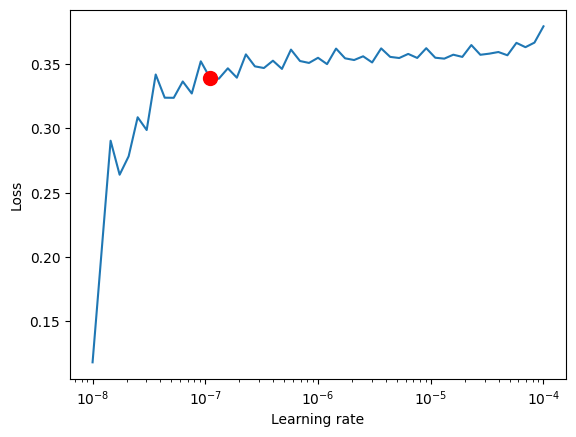

In [99]:
fig = lr_finder.plot(suggest=True)
fig.show()

In [ ]:
trainer

In [58]:
tuner.scale_batch_size(frcnn, datamodule=dm, mode='power')

/Users/jsh/.local/share/virtualenvs/spacecrafts-01zDKSDz-python/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
/Users/jsh/.local/share/virtualenvs/spacecrafts-01zDKSDz-python/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
Finding best initial lr:   0%|          | 0/100 [56:47<?, ?it/s]


/Users/jsh/.local/share/virtualenvs/spacecrafts-01zDKSDz-python/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 2 succeeded, trying batch size 4
/Users/jsh/.local/share/virtualenvs/spacecrafts-01zDKSDz-python/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/jsh/.local/share/virtualenvs/spacecrafts-01zDKSDz-python/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 4 succeeded, trying batch size 8
/Users/jsh/.local/share/virtualenvs/spacecrafts-01zDKSDz-python/lib/python3.10/site-packages/pytorch_lightning/tra

2

# 🩼 | Helper Functions

In [45]:
def get_bbox(image_id, labels):
    """Get bbox coordinates as list from dataframe for given image id."""
    return labels.loc[image_id].loc[["xmin", "ymin", "xmax", "ymax"]].values

def display_image_from_file(image_id, images_dir=IMAGES_DIRECTORY, show_bbox=False, labels=None, pred_bbox=None):
    """Display image given image ID. Annotate with bounding box if `show_bbox` is True."""
    img = cv2.imread(str(images_dir / f"{image_id}.png"))
    fig, ax = plt.subplots()
    # cv2 reads images as BGR order; we should flip them to RGB for matplotlib
    # ref: https://stackoverflow.com/questions/54959387/rgb-image-display-in-matplotlib-plt-imshow-returns-a-blue-image
    ax.imshow(np.flip(img, axis=-1))

    if show_bbox:
        xmin, ymin, xmax, ymax = get_bbox(image_id, labels)
        patch = Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='white', linewidth=1)
        ax.add_patch(patch)

    if pred_bbox is not None:
        xmin, ymin, xmax, ymax = pred_bbox
        patch = Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='blue', linewidth=1)
        ax.add_patch(patch)       

In [166]:
def centered_box(img_size=IMAGE_RESIZED, scale=0.1):
    """
    Return coordinates for a centered bounding box on the image, defaulting to 10% of the image's height and width.
    """
    # Get image dimensions
    width, height = img_size
    # Calculate the center of the image
    center_x, center_y = width // 2, height // 2
    # Calculate 10% of the image's height and width for the bounding box
    box_width, box_height = width * scale, height * scale
    # Calculate top-left corner of the bounding box
    x1 = center_x - box_width // 2
    y1 = center_y - box_height // 2
    # Calculate bottom-right corner of the bounding box
    x2 = center_x + box_width // 2
    y2 = center_y + box_height // 2

    return [x1, y1, x2, y2]

def get_predicted_bboxes(preds):
    """
    Extract the top bounding box prediction from the predications. If no prediction then use a centered box.
    """
    preds = [{k: v.to('cpu') if isinstance(v, torch.Tensor) else v for k, v in p.items()} for p in preds]
    bbox_list = []
    
    for pred in preds:
        if len(pred['boxes']) > 0:
            bbox_list.append(pred['boxes'][0])
        else:
            bbox_list.append(torch.Tensor(centered_box()))
    return torch.stack(bbox_list)

def get_target_bboxes(targets):
    """
    Extract the bounding boxes from the 'targets' portion of a dataloader batch.
    """
    targets = [{k: v.to('cpu') if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
    return torch.stack([target['boxes'] for target in targets])


Params length: 70


## 📋 | Result

In [172]:
def show_image(img_idx=None, img=None, pred_bbox=None, target_bbox=None, ax=None):
    img = np.transpose(img, (1,2,0))
    ax.imshow(img)

    if target_bbox is not None:
        xmin, ymin, xmax, ymax = target_bbox
        height = ymax - ymin
        width = xmax - xmin
        patch = Rectangle((xmin, ymin), width, height, fill=False, edgecolor='white', linewidth=2)
        ax.add_patch(patch)
        # ax.text(xmin + width - 63, ymin + height - 30, 'Target', color='r', ha='center', va='center', fontsize=8, bbox=dict(facecolor='white', edgecolor='white', alpha=0.5))

    if pred_bbox is not None:
        xmin, ymin, xmax, ymax = pred_bbox
        height = ymax - ymin
        width = xmax - xmin
        patch = Rectangle((xmin, ymin), width, height, fill=False, edgecolor='blue', linewidth=2)
        ax.add_patch(patch)
        # ax.text(xmin + width - 55, ymin + height - 30, 'Pred', color='white', ha='center', va='center', fontsize=8, bbox=dict(facecolor='blue', edgecolor='blue', alpha=0.5))
    
    if (pred_bbox is not None) and (target_bbox is not None):
       jac = jaccard_index(pred_bbox.reshape(1,4), target_bbox.reshape(1,4))
    else:
       jac = 'n/a' 

    title = f'Image: {img_idx}\nJaccard: {jac[0]:.4f}'
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

In [173]:
def display_images(images, targets, preds, cols=2, device='cpu'):
    images = list(image.to(device) for image in images)
    
    rows = (len(images) + cols - 1) // 2
    fig = plt.figure(figsize=(15, 5*rows))
    predicted_bboxes = get_predicted_bboxes(preds).detach().cpu().numpy()
    target_bboxes = get_target_bboxes(targets).cpu().numpy().squeeze()
    
    for idx, target in enumerate(targets):
        img_idx = target['image_id']
        target_bbox = target_bboxes[idx]
        pred_bbox = predicted_bboxes[idx]
        img = images[idx]
        ax = fig.add_subplot(rows, cols, idx + 1)
        show_image(img_idx, img, pred_bbox, target_bbox, ax)

In [194]:
for i, data in enumerate(valid_dl):
    if i == 1:
        images, targets = data
        images = list(image.to('cpu') for image in images)
        targets = [{k: v.to('cpu') if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
        model.to('cpu')
        predictions = model(images)
        break

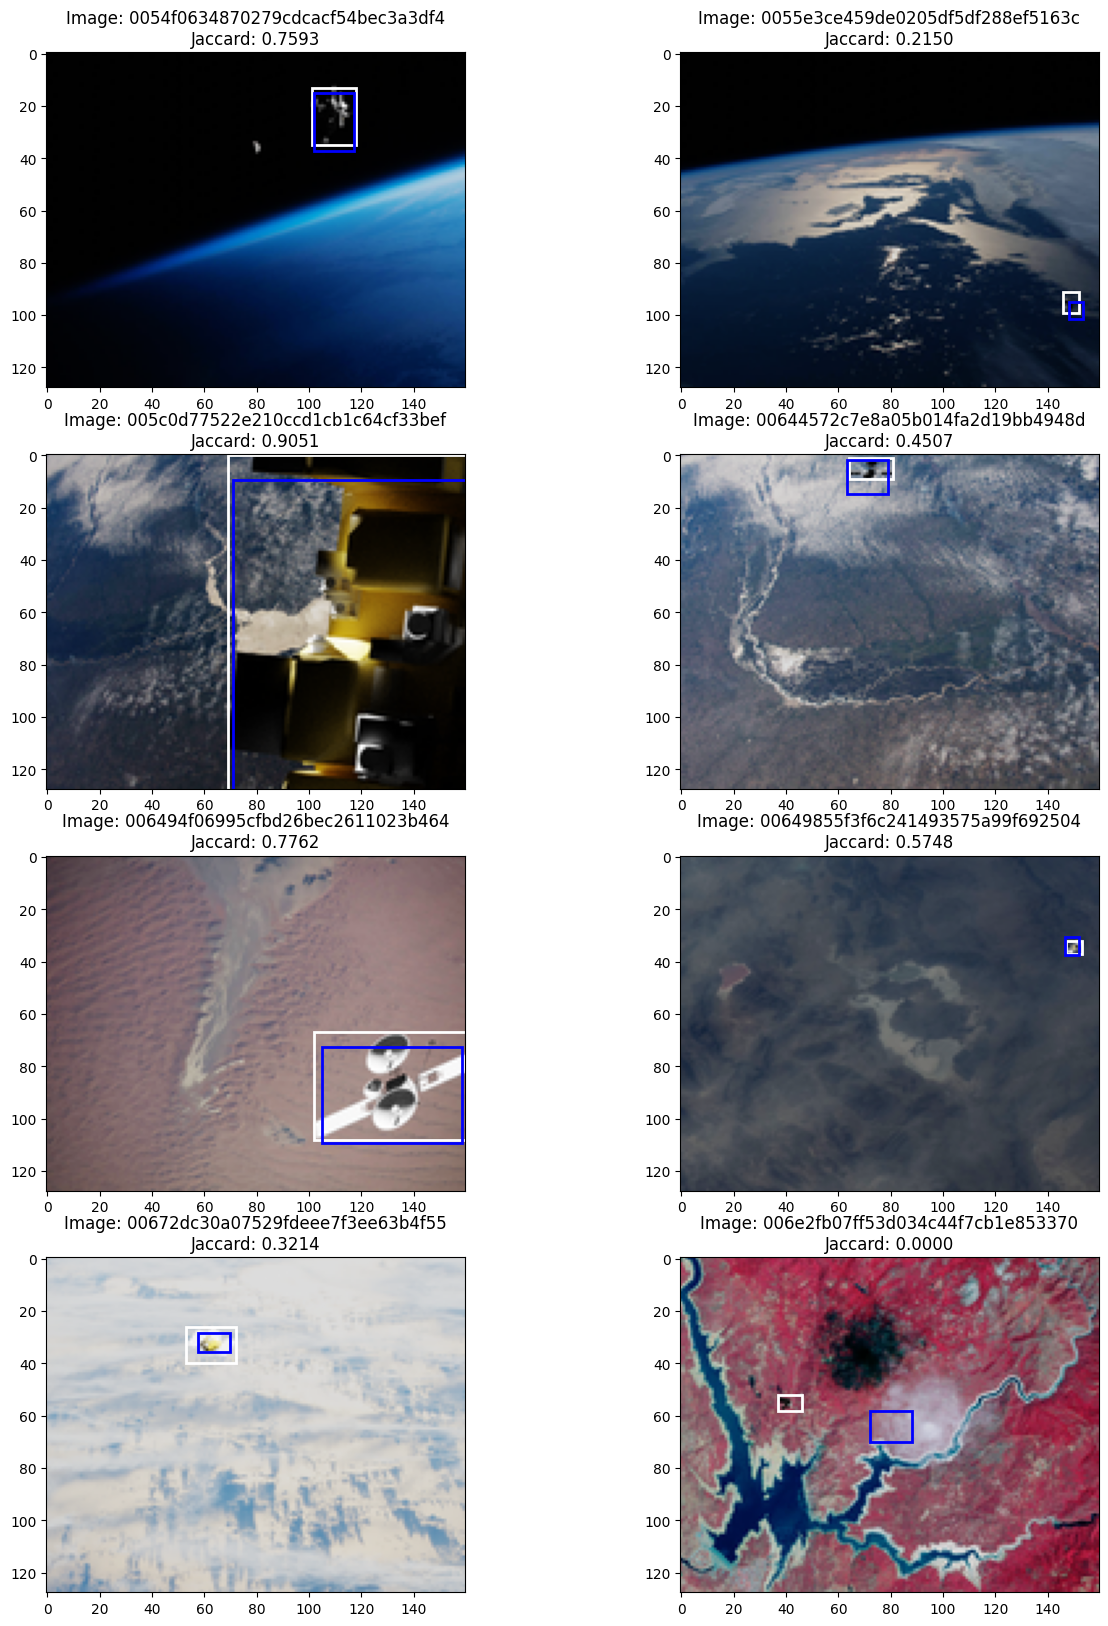

In [195]:
display_images(images[:4], targets[:4], predictions[:4], cols=2)

In [14]:
torch.save(frcnn, "/Users/jsh/code/drivendata/spacecrafts/submission_src/lightning_model.pt")

In [114]:
model2 = torch.load("/Users/jsh/code/drivendata/spacecrafts/submission_src/lightning_model.pt")